In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Paths
BASE_DIR = Path(r'c:\Users\Acer\Desktop\Forex-Signal-App')
DATA_DIR = BASE_DIR / 'data'
MODEL_DIR = BASE_DIR / 'models' / 'signal_generator_v18'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Constants
TIMEFRAMES = ['1min', '5min', '15min', '30min', '1h', '4h']
FORWARD_BARS = 24          # Look ahead window (longer for dynamic moves)
ATR_PERIOD = 14
TP_ATR_MULT = 1.5          # Target Profit = 1.5 * ATR
SL_ATR_MULT = 1.0          # Stop Loss = 1.0 * ATR

print(f"🚀 FOREX SIGNAL V18: Buy-Only Dynamic Strategy")
print(f"✓ Model Directory: {MODEL_DIR}")

🚀 FOREX SIGNAL V18: Buy-Only Dynamic Strategy
✓ Model Directory: c:\Users\Acer\Desktop\Forex-Signal-App\models\signal_generator_v18


In [25]:
# 1. Load Data
def load_tf_data(timeframe, dataset_type='train'):
    filename = f'EURUSD_{timeframe}.csv'
    file_path = DATA_DIR / dataset_type / filename
        
    if not file_path.exists():
        print(f"⚠️ Warning: {file_path} not found.")
        return None
        
    df = pd.read_csv(file_path)
    df.columns = [c.lower() for c in df.columns]
    
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        df.sort_index(inplace=True)
    
    return df

timeframes_map = {
    # '1min': 'm1',
    # '5min': 'm5',
    '15min': 'm15',
    '30min': 'm30',
    '1h': 'h1',
    '4h': 'h4'
}

dfs_train = {}
dfs_test = {}

print("Loading TRAIN data...")
for tf_name, tf_code in timeframes_map.items():
    dfs_train[tf_name] = load_tf_data(tf_code, 'train')

print("\nLoading TEST data...")
for tf_name, tf_code in timeframes_map.items():
    dfs_test[tf_name] = load_tf_data(tf_code, 'test')

Loading TRAIN data...

Loading TEST data...


In [17]:
# 2. Feature Engineering (Including ATR)
def add_features(df):
    if df is None or len(df) == 0:
        return None
    df = df.copy()
    
    # --- ATR (Crucial for Dynamic Target) ---
    high_low = df['high'] - df['low']
    high_close = (df['high'] - df['close'].shift()).abs()
    low_close = (df['low'] - df['close'].shift()).abs()
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    df['atr'] = true_range.rolling(ATR_PERIOD).mean()
    
    # --- Trend Indicators ---
    for p in [9, 21, 50, 200]:
        df[f'ema_{p}'] = df['close'].ewm(span=p, adjust=False).mean()
        df[f'dist_ema_{p}'] = (df['close'] - df[f'ema_{p}']) / df[f'ema_{p}']
        
    # --- Oscillators ---
    # RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / (loss + 1e-10)
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    
    # --- Volatility ---
    df['bb_mid'] = df['close'].rolling(window=20).mean()
    df['bb_std'] = df['close'].rolling(window=20).std()
    df['bb_upper'] = df['bb_mid'] + (df['bb_std'] * 2)
    df['bb_lower'] = df['bb_mid'] - (df['bb_std'] * 2)
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_mid']
    
    # --- Time ---
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    
    return df.dropna()

print("Processing features...")
processed_train = {k: add_features(v) for k, v in dfs_train.items()}
processed_test = {k: add_features(v) for k, v in dfs_test.items()}
print("Done.")

Processing features...
Done.


In [18]:
# 3. Dynamic Buy-Only Target Creation
def create_buy_target(df, tp_mult, sl_mult, forward_bars):
    targets = []
    closes = df['close'].values
    highs = df['high'].values
    lows = df['low'].values
    atrs = df['atr'].values
    
    for i in range(len(df) - forward_bars):
        entry = closes[i]
        atr = atrs[i]
        
        if np.isnan(atr) or atr == 0:
            targets.append(0)
            continue
            
        tp = entry + (atr * tp_mult)
        sl = entry - (atr * sl_mult)
        
        outcome = 0 # 0 = WAIT/LOSS
        
        for j in range(1, forward_bars + 1):
            future_high = highs[i+j]
            future_low = lows[i+j]
            
            # Check SL first (conservative)
            if future_low <= sl:
                outcome = 0
                break
            
            # Check TP
            if future_high >= tp:
                outcome = 1 # BUY WIN
                break
                
        targets.append(outcome)
        
    targets.extend([0] * forward_bars)
    return np.array(targets)

print("Creating Dynamic Targets (Buy Only)...")
train_datasets = {}
test_datasets = {}

for tf, df in processed_train.items():
    if df is not None and len(df) > FORWARD_BARS:
        df = df.copy()
        df['target'] = create_buy_target(df, TP_ATR_MULT, SL_ATR_MULT, FORWARD_BARS)
        train_datasets[tf] = df.iloc[:-FORWARD_BARS]
        print(f"  {tf}: Buy Signals = {df['target'].sum()} ({df['target'].mean()*100:.2f}%)")

for tf, df in processed_test.items():
    if df is not None and len(df) > FORWARD_BARS:
        df = df.copy()
        df['target'] = create_buy_target(df, TP_ATR_MULT, SL_ATR_MULT, FORWARD_BARS)
        test_datasets[tf] = df.iloc[:-FORWARD_BARS]

Creating Dynamic Targets (Buy Only)...
  15min: Buy Signals = 83717 (37.31%)
  30min: Buy Signals = 41791 (37.26%)
  1h: Buy Signals = 21953 (39.15%)
  4h: Buy Signals = 5649 (39.02%)


In [26]:
# 4. Train Binary Classifiers
models = {}
scalers = {}
feature_cols_dict = {}

for tf, df_train in train_datasets.items():
    print(f"\nTraining {tf}...")
    
    cols = [c for c in df_train.columns if c not in ['target', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'volume', 'atr']]
    
    X_train = df_train[cols]
    y_train = df_train['target']
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Calculate scale_pos_weight for imbalance
    # weight = count(negative) / count(positive)
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    scale_weight = n_neg / n_pos if n_pos > 0 else 1.0
    
    print(f"  Positives: {n_pos}, Negatives: {n_neg}, Weight: {scale_weight:.2f}")
    
    model = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        scale_pos_weight=scale_weight, # Handle imbalance
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    model.fit(X_train_scaled, y_train)
    
    models[tf] = model
    scalers[tf] = scaler
    feature_cols_dict[tf] = cols
    
print("\nTraining Complete.")


Training 15min...
  Positives: 83717, Negatives: 140622, Weight: 1.68

Training 30min...
  Positives: 41791, Negatives: 70360, Weight: 1.68

Training 1h...
  Positives: 21953, Negatives: 34102, Weight: 1.55

Training 4h...
  Positives: 5649, Negatives: 8806, Weight: 1.56

Training Complete.



==================== 15min EVALUATION ====================
Accuracy: 0.5201
              precision    recall  f1-score   support

           0       0.64      0.51      0.57     30931
           1       0.40      0.54      0.46     18833

    accuracy                           0.52     49764
   macro avg       0.52      0.52      0.51     49764
weighted avg       0.55      0.52      0.53     49764



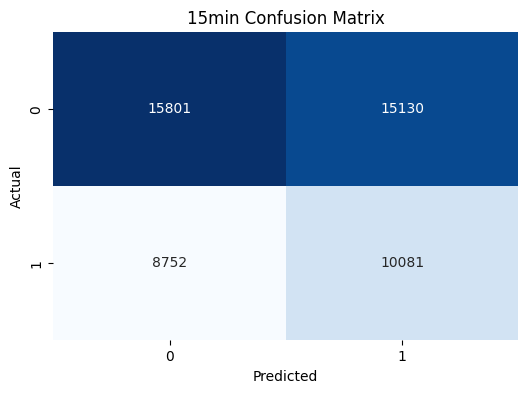

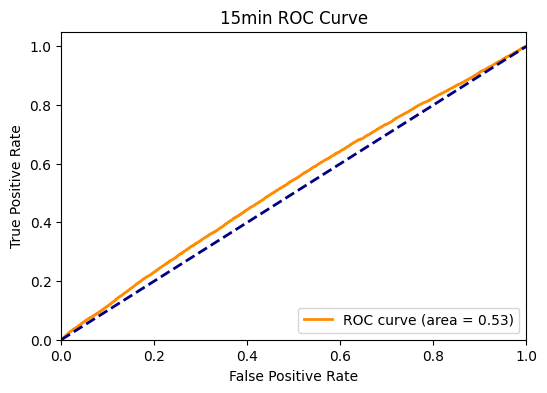


==================== 30min EVALUATION ====================
Accuracy: 0.5070
              precision    recall  f1-score   support

           0       0.63      0.51      0.56     15422
           1       0.39      0.51      0.44      9442

    accuracy                           0.51     24864
   macro avg       0.51      0.51      0.50     24864
weighted avg       0.54      0.51      0.51     24864



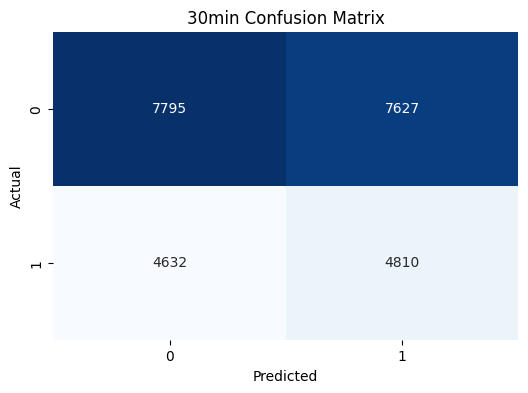

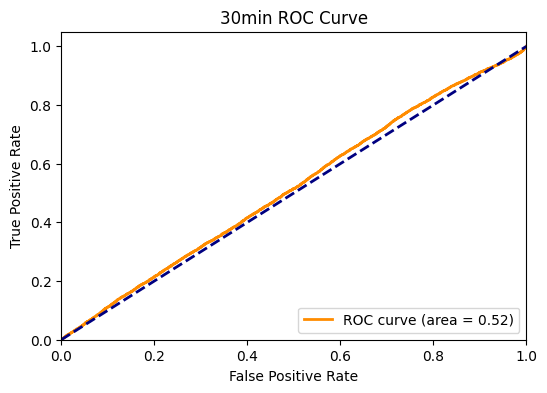


==================== 1h EVALUATION ====================
Accuracy: 0.4945
              precision    recall  f1-score   support

           0       0.60      0.48      0.54      7539
           1       0.39      0.51      0.44      4872

    accuracy                           0.49     12411
   macro avg       0.50      0.50      0.49     12411
weighted avg       0.52      0.49      0.50     12411



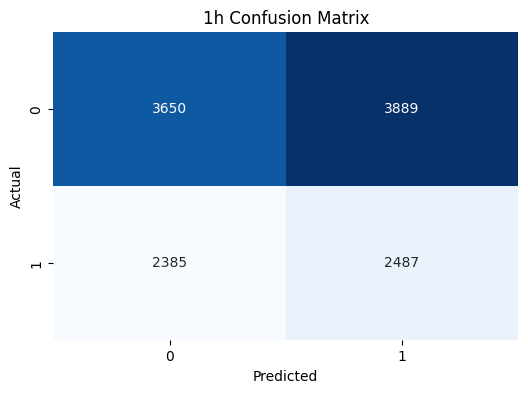

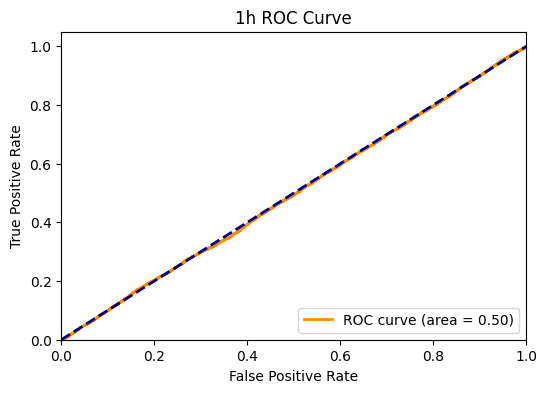


==================== 4h EVALUATION ====================
Accuracy: 0.5017
              precision    recall  f1-score   support

           0       0.60      0.48      0.53      1888
           1       0.41      0.53      0.46      1289

    accuracy                           0.50      3177
   macro avg       0.51      0.51      0.50      3177
weighted avg       0.52      0.50      0.51      3177



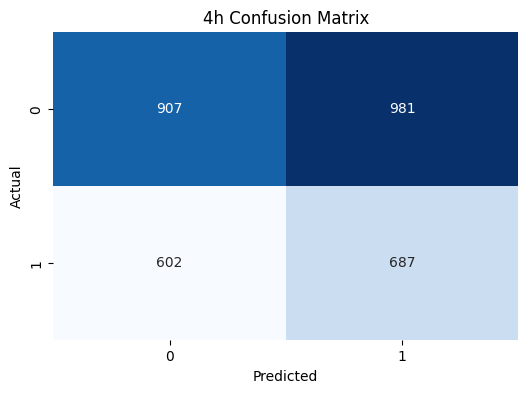

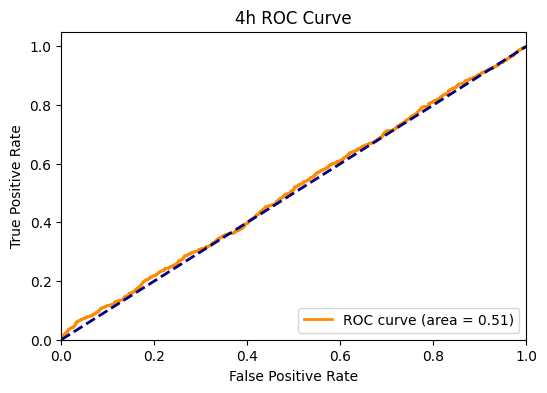

In [27]:
# 5. Detailed Evaluation & Visualization
def evaluate_model_detailed(model, scaler, df, cols, tf_name):
    X = df[cols]
    y_true = df['target']
    X_scaled = scaler.transform(X)
    
    # Predict Probabilities
    y_probs = model.predict_proba(X_scaled)[:, 1]
    
    # Thresholding (Default 0.5, but we can tune)
    threshold = 0.5
    y_pred = (y_probs > threshold).astype(int)
    
    print(f"\n{'='*20} {tf_name} EVALUATION {'='*20}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{tf_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{tf_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_probs

# Evaluate on Test Data
for tf, df_test in test_datasets.items():
    if tf in models:
        evaluate_model_detailed(models[tf], scalers[tf], df_test, feature_cols_dict[tf], tf)

In [21]:
# 6. Save Models
joblib.dump(models, MODEL_DIR / 'models_dict_v18.joblib')
joblib.dump(scalers, MODEL_DIR / 'scalers_dict_v18.joblib')
joblib.dump(feature_cols_dict, MODEL_DIR / 'feature_cols_dict_v18.joblib')

config = {
    'timeframes': TIMEFRAMES,
    'tp_atr_mult': TP_ATR_MULT,
    'sl_atr_mult': SL_ATR_MULT,
    'forward_bars': FORWARD_BARS,
    'strategy': 'buy_only_dynamic_atr'
}
joblib.dump(config, MODEL_DIR / 'config_v18.joblib')
print("Models saved.")

Models saved.
